<a href="https://colab.research.google.com/github/nuyhc/RhythmStudy/blob/main/1.%20PyTorch/PTM_1_%EB%B0%95%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/deep-learning-with-pytorch/dlwpt-code

Cloning into 'dlwpt-code'...
remote: Enumerating objects: 703, done.
remote: Total 703 (delta 0), reused 0 (delta 0), pack-reused 703
Receiving objects: 100% (703/703), 176.00 MiB | 31.04 MiB/s, done.
Resolving deltas: 100% (309/309), done.
Checking out files: 100% (228/228), done.


# [PTM] 1장. 딥러닝과 파이토치 라이브러리 소개

1. 파이썬을 실행해 프롬프트를 띄어보자  
    a. 어떤 버전을 사용 중인가?  
    b. import torch가 되는가? 어떤 버전의 파이토치를 설치했는가?  
    c. torch.cuda.is_available() 실행 결과는? 사용하는 하드웨어에 맞는 내용이 출력되는가?  

2. 주피터 노트북 서버를 띄어보자  
    a. 주피터가 사용하는 파이썬 버전은 무엇인가?  
    b. 주피터가 사용하는 torch 라이브러리 경로와 터미널을 띄워 import한 경로가 같은가?  

In [ ]:
# 1. 파이썬을 실행해 프롬프트를 띄어보자
# a. 어떤 버전을 사용 중인가?

!python3 --version

Python 3.8.15


In [ ]:
# b. import torch가 되는가? 어떤 버전의 파이토치를 설치했는가?

import torch

print(torch.__version__)

1.12.1+cu113


In [ ]:
# c. torch.cuda.is_available() 실행 결과는? 사용하는 하드웨어에 맞는 내용이 출력되는가?
# torch.cuda.is_available()

torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device(type='cuda')

In [ ]:
# 2. 주피터 노트북 서버를 띄어보자
# a. 주피터가 사용하는 파이썬 버전은 무엇인가?

!jupyter --version

Selected Jupyter core packages...
IPython          : 7.9.0
ipykernel        : 5.3.4
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 4.11.2
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : not installed
nbconvert        : 5.6.1
nbformat         : 5.7.0
notebook         : 5.7.16
qtconsole        : not installed
traitlets        : 5.1.1


In [ ]:
# b. 주피터가 사용하는 torch 라이브러리 경로와 터미널을 띄워 import한 경로가 같은가?


#[PTM] 2장. 사전 훈련된 신경망

1. 말-얼룩말 모델에 골든 리트리버 이미지를 넣어보자.  
    a. 이미지를 어떻게 준비해야 할까?  
    b. 출력 결과는 어떤가?  

2. hubconf.py 파일이 있는 깃헙 프로젝트 저장소를 찾아라.  
    a. 얼마나 많은 저장소가 나오는가?  
    b. hubconf.py가 있는 재미있는 프로젝트를 찾아보라. 문서에서 프로젝트 목표를 이해할 수 있는가?  
    c. 프로젝트를 북마크해두고 이 책을 다 읽은 후 다시 방문해보라. 세부 구현을 이해할 수 있는가?


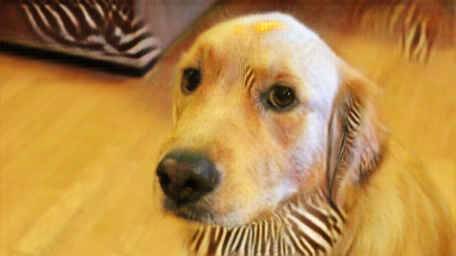

In [14]:
# 1. 말-얼룩말 모델에 골든 리트리버 이미지를 넣어보자.
# a. 이미지를 어떻게 준비해야 할까?
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

netG = ResNetGenerator()

model_path = '/content/dlwpt-code/data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

netG.eval()

preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

img = Image.open('/content/dlwpt-code/data/p1ch2/bobby.jpg')

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

batch_out = netG(batch_t)
batch_out

out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
# out_img.save('../data/p1ch2/zebra.jpg')


# b. 출력 결과는 어떤가?
out_img

In [ ]:
# 사전 훈련된 모델 불러오기

from torchvision import models

dir(models)

In [ ]:
alexnet = models.AlexNet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
resnet = models.resnet101(pretrained=True)
resnet

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 기본적인 전처리 함수로 빠르게 파이프라인을 만들 수 있는 transfroms

from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [ ]:
from PIL import Image

img = Image.open('/content/dlwpt-code/data/p1ch2/bobby.jpg')
img.show()

In [ ]:
# 만들어놓은 전처리 파이프라인으로 이미지 통과

img_t = preprocess(img)
img.show()

In [ ]:
import torch

batch_t = torch.unsqueeze(img_t, 0)
resnet.eval()  # 훈련된 모델에 새로운 데이터를 넣어 결과를 보는 과정 (추론 inferenct)

out = resnet(batch_t)
out

tensor([[-3.4803e+00, -1.6618e+00, -2.4515e+00, -3.2662e+00, -3.2466e+00,
         -1.3611e+00, -2.0465e+00, -2.5112e+00, -1.3043e+00, -2.8900e+00,
         -1.6862e+00, -1.3055e+00, -2.6129e+00, -2.9645e+00, -2.4300e+00,
         -2.8143e+00, -3.3019e+00, -7.9404e-01, -6.5183e-01, -1.2308e+00,
         -3.0193e+00, -3.9457e+00, -2.2675e+00, -1.0811e+00, -1.0232e+00,
         -1.0442e+00, -3.0918e+00, -2.4613e+00, -2.1964e+00, -3.2354e+00,
         -3.3013e+00, -1.8553e+00, -2.0921e+00, -2.1327e+00, -1.9102e+00,
         -3.2403e+00, -1.1396e+00, -1.0925e+00, -1.2186e+00, -9.3332e-01,
         -4.5093e-01, -1.5489e+00,  1.4161e+00,  1.0871e-01, -1.8442e+00,
         -1.4806e+00,  9.6227e-01, -9.9456e-01, -3.0060e+00, -2.7384e+00,
         -2.5798e+00, -2.0666e+00, -1.8022e+00, -1.9328e+00, -1.7726e+00,
         -1.3041e+00, -4.5848e-01, -2.0537e+00, -3.2804e+00, -5.0451e-01,
         -3.8174e-01, -1.1147e+00, -7.3998e-01, -1.4299e+00, -1.4883e+00,
         -2.1073e+00, -1.7373e+00, -4.

In [ ]:
with open('/content/dlwpt-code/data/p1ch2/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

labels

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [ ]:
# tensor에서 최댓값과 이 최댓값이 들어 있는 부분의 인텍스 출력

_, index = torch.max(out, 1)
_, index

(tensor([15.6744], grad_fn=<MaxBackward0>), tensor([207]))

In [ ]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

('golden retriever', 96.29335021972656)

In [ ]:
_, indices = torch.sort(out, descending=True)
_, indices
# [(index[0], percentage[idx].item()) for idx in indices[0][0:5]]

(tensor([[ 1.5674e+01,  1.2140e+01,  9.8436e+00,  9.5398e+00,  8.9547e+00,
           7.7051e+00,  7.5155e+00,  7.5066e+00,  7.0547e+00,  6.9794e+00,
           6.4168e+00,  6.4046e+00,  6.1872e+00,  6.1745e+00,  5.9932e+00,
           5.8567e+00,  5.8086e+00,  5.7791e+00,  5.6958e+00,  5.6891e+00,
           5.6885e+00,  5.6031e+00,  5.6016e+00,  5.5149e+00,  5.4996e+00,
           5.3248e+00,  5.2050e+00,  5.1851e+00,  5.0895e+00,  4.9467e+00,
           4.8873e+00,  4.8719e+00,  4.8250e+00,  4.7733e+00,  4.7226e+00,
           4.6280e+00,  4.5523e+00,  4.4584e+00,  4.3620e+00,  4.3456e+00,
           4.3443e+00,  4.3379e+00,  4.2841e+00,  4.2790e+00,  4.2622e+00,
           4.2074e+00,  4.0970e+00,  4.0880e+00,  4.0282e+00,  4.0010e+00,
           3.9907e+00,  3.9127e+00,  3.7953e+00,  3.7732e+00,  3.7192e+00,
           3.7156e+00,  3.6606e+00,  3.6402e+00,  3.6187e+00,  3.5778e+00,
           3.5698e+00,  3.5563e+00,  3.5030e+00,  3.5028e+00,  3.4956e+00,
           3.4884e+00,  3

In [ ]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('golden retriever', 96.29335021972656),
 ('Labrador retriever', 2.8081188201904297),
 ('cocker spaniel, English cocker spaniel, cocker', 0.2826734781265259),
 ('redbone', 0.2086300402879715),
 ('tennis ball', 0.11621593683958054)]

### CycleGAN

In [ ]:
import torch
import torch.nn as nn


class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [ ]:
# ResNetGenerator 클래스 인스턴스 생성

netG = ResNetGenerator()

In [ ]:
# model의 가중치를 ResNetGenerator에 로드할 때 load_state_dict 함수를 사용

model_path = '/content/dlwpt-code/data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
# model에 새로운 데이터를 넣어 추론하는 과정 (eval)

netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [ ]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [ ]:
img = Image.open('/content/dlwpt-code/data/p1ch2/horse.jpg')
img

In [ ]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# 생성자 출력 batch_out
batch_out = netG(batch_t)
batch_out

tensor([[[[ 0.3469,  0.3422,  0.3519,  ...,  0.5198,  0.4535,  0.4788],
          [ 0.3839,  0.3595,  0.2991,  ...,  0.4433,  0.3944,  0.4282],
          [ 0.3391,  0.3547,  0.3415,  ...,  0.4124,  0.3843,  0.4571],
          ...,
          [ 0.2666,  0.2619,  0.2637,  ...,  0.3536,  0.4634,  0.4651],
          [ 0.1705,  0.1176,  0.1360,  ...,  0.4182,  0.4508,  0.4139],
          [ 0.1020,  0.0393,  0.1127,  ...,  0.3672,  0.4050,  0.3818]],

         [[ 0.2504,  0.2115,  0.2599,  ...,  0.3931,  0.3681,  0.4027],
          [ 0.2051,  0.2126,  0.2039,  ...,  0.3052,  0.2960,  0.3362],
          [ 0.2277,  0.2202,  0.2134,  ...,  0.2913,  0.3152,  0.3815],
          ...,
          [ 0.3045,  0.2703,  0.2502,  ...,  0.2361,  0.3240,  0.3590],
          [ 0.2004,  0.0905,  0.1348,  ...,  0.2848,  0.3338,  0.2588],
          [ 0.1276,  0.1313,  0.1398,  ...,  0.2573,  0.3042,  0.2946]],

         [[ 0.4418,  0.4246,  0.4886,  ...,  0.3578,  0.3949,  0.4387],
          [ 0.3700,  0.4238,  

In [ ]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
# out_img.save('/content/dlwpt-code/data/p1ch2/zebra.jpg')
out_img

### NeuralTalk2

In [ ]:
!git clone https://github.com/deep-learning-with-pytorch/ImageCaptioning.pytorch.git

Cloning into 'ImageCaptioning.pytorch'...
remote: Enumerating objects: 515, done.
remote: Total 515 (delta 0), reused 0 (delta 0), pack-reused 515
Receiving objects: 100% (515/515), 206.53 MiB | 41.11 MiB/s, done.
Resolving deltas: 100% (327/327), done.
Checking out files: 100% (28/28), done.


In [ ]:
%pwd
%cd /content/ImageCaptioning.pytorch

/content/ImageCaptioning.pytorch


In [ ]:
!python eval.py --model ./data/FC/fc-model.pth --infos_path ./data/FC/fc-infos.pkl --image_folder ./data

DataLoaderRaw loading images from folder:  ./data
0
listing all images in directory ./data
DataLoaderRaw found  2  images
Traceback (most recent call last):
  File "eval.py", line 132, in <module>
    loss, split_predictions, lang_stats = eval_utils.eval_split(
  File "/content/ImageCaptioning.pytorch/eval_utils.py", line 106, in eval_split
    seq, _ = model.sample(fc_feats, att_feats, eval_kwargs)
  File "/content/ImageCaptioning.pytorch/models/FCModel.py", line 160, in sample
    return self.sample_beam(fc_feats, att_feats, opt)
  File "/content/ImageCaptioning.pytorch/models/FCModel.py", line 141, in sample_beam
    xt = self.img_embed(fc_feats[k:k+1]).expand(beam_size, self.input_encoding_size)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/linear.py", line 114, in forward
    return F.linear(input, self.weight, self.bias)


### 토치 허브

In [2]:
import torch
from torch import hub

resnet18_model = hub.load('pytorch/vision:main',  # 깃헙 저장소 이름과 브랜치
                          'resnet18',  # 진입점이 되는 함수 이름
                          pretrained=True)  # 키워드 인자
resnet18_model

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/pytorch_vision_main/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
/root/.cache/torch/hub/pytorch_vision_main/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.cache/torch/hub/pytorch_vision_main/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/h

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#[PTM] 3장. 텐서 구조체



---

### 텐서의 핵심
숫자값으로 많든 파이썬 리스트나 튜플 객체는 메모리에 따로따로 할당된다.  
반면, 파이토치 텐서나 넘파이 배열은 파이썬 객체가 아닌 unboxing된 C언어의 숫자 타입을 포함한 연속적인 메모리가 할당되고 이에 대한 뷰를 제공한다.  

In [6]:
points = torch.zeros(6)
points[0] = 4.0
points[1] = 1.0
points[2] = 5.0
points[3] = 3.0
points[4] = 2.0
points[5] = 1.0
points

tensor([4., 1., 5., 3., 2., 1.])

In [7]:
# 생성자에 파이썬 리스트 넘기기
points = torch.tensor([4.0, 1.0, 5.0, 3.0, 2.0, 1.0])
points

tensor([4., 1., 5., 3., 2., 1.])

In [9]:
# 첫 번째 점의 좌표 읽기
float(points[0]), float(points[1])

(4.0, 1.0)

In [10]:
# 2차원 텐서
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [11]:
# 리스트의 리스트를 생성자로 넘겨주고 텐처의 차원 확인
points.shape

torch.Size([3, 2])

In [13]:
# zeros나 ones로 차원별 크기 정보를 튜플로 만들기
points = torch.zeros(3, 2)
points

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

### 텐서 인덱싱

In [16]:
points[1:]  # 첫 번째 이후 모든 행에 대해, 암묵적으로 모든 열이 포함됨

tensor([[0., 0.],
        [0., 0.]])

In [18]:
points[1:, 0]  # 첫 번째 이후 모든 행에 대해 첫 번째 열만 포함됨

tensor([0., 0.])

In [19]:
points[None]  # 길이가 1인 차원을 추가함. unsqueeze와 동일함

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.]]])

### 이름이 있는 텐서

In [20]:
img_t = torch.randn(3, 5, 5)  # 각각이 [채널 크기, 행 크기, 열 크기]가 됨
weights = torch.tensor([0.2126, 0.7152, 0.0722])

In [21]:
# 배치 크기 2인 텐서
batch_t = torch.randn(2, 3, 5, 5)  # [채널 크기, 행 크기, 열 크기]

In [23]:
# RGB 채널은 -3번 차원에 있는 것으로 일반화할 수 있음
# 배치 차원 유므에 상관없이 평균을 구할 수 있음
img_gray_naive = img_t.mean(-3)
batch_gray_naive = batch_t.mean(-3)
img_gray_naive.shape, batch_gray_naive.shape

(torch.Size([5, 5]), torch.Size([2, 5, 5]))

In [27]:
# pytorch에서의 브로드캐스팅 연산
unsqueezed_weights = weights.unsqueeze(-1).unsqueeze(-1)
img_weights = (img_t * unsqueezed_weights)
batch_weights = (batch_t * unsqueezed_weights)
img_gray_weighted = img_weights.sum(-3)
batch_gray_weighted = batch_weights.sum(-3)
batch_weights.shape, batch_t.shape, unsqueezed_weights.shape

(torch.Size([2, 3, 5, 5]), torch.Size([2, 3, 5, 5]), torch.Size([3, 1, 1]))

In [28]:
# 차원별로 이름을 부여하고 곱셈 후 합을 구하는 경우 사용 할 수 있음
# einsum 함수
img_gray_weighted_fancy = torch.einsum('...chw,c->...hw', img_t, weights)
img_gray_weighted_fancy

tensor([[-0.8755, -0.1684,  1.2147, -0.1639,  0.2134],
        [ 0.9833, -0.0242,  0.2883,  1.8565, -0.1609],
        [-0.6376, -0.7787,  0.4429,  0.7084, -0.3895],
        [ 1.0349,  0.1547,  0.4424, -0.5018, -0.7948],
        [-0.5875, -0.4061, -1.1368, -0.8204, -1.5046]])

In [29]:
batch_gray_weighted_fancy = torch.einsum('...chw,c->...hw', batch_t, weights)
batch_gray_weighted_fancy.shape

torch.Size([2, 5, 5])

In [33]:
# 이름 지정이 가능한 텐서
weights_named = torch.tensor([0.2126, 0.7152, 0.0722], names=[('channels')])
weights_named

tensor([0.2126, 0.7152, 0.0722], names=('channels',))

In [35]:
# 텐서를 먼저 만들고 나중에 이름 지정
# redefine_names 함수
img_named = img_t.refine_names(..., 'channels', 'rows', 'columns')
batch_named = batch_t.refine_names(..., 'channels', 'rows', 'columns')
print("img named:", img_named.shape, img_named.names)
print("batch named:", batch_named.shape, batch_named.names)

img named: torch.Size([3, 5, 5]) ('channels', 'rows', 'columns')
batch named: torch.Size([2, 3, 5, 5]) (None, 'channels', 'rows', 'columns')


In [40]:
# 빠진 차원을 채우고, 존재하는 차원을 올바른 순서로 바꿈
# align_as 함수
weights_aligned = weights_named.align_as(img_named)
weights_aligned.shape, weights_aligned.names

(torch.Size([3, 1, 1]), ('channels', 'rows', 'columns'))

In [41]:
# 차원 인수를 허용하는 함수들은 이름이 붙은 차원도 받아들임
# sum 함수
gray_named = (img_named * weights_aligned).sum('channels')
gray_named.shape, gray_named.names

(torch.Size([5, 5]), ('rows', 'columns'))

In [42]:
# Error: 이름이 다른 차원을 결합
gray_named = (img_named[..., 3] * weights_named).sum('channels')

RuntimeError: ignored

In [43]:
# 차원 이름에 None을 넣어 이름 없는 텐서 생성
gray_plain = gray_named.rename(None)
gray_plain.shape, gray_plain.names

(torch.Size([5, 5]), (None, None))

### 텐서의 dtype 속성관리

In [45]:
# 생성자에 dtype 인자를 정확하게 전달
double_points = torch.ones(10, 2, dtype=torch.double)
double_points

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64)

In [47]:
short_points = torch.tensor([[1, 2], [3, 4]], dtype=torch.short)
short_points

tensor([[1, 2],
        [3, 4]], dtype=torch.int16)

In [49]:
# 캐스팅 메소드를 사용한 타입 변환
double_points = torch.zeros(10, 2).double()
short_points = torch.ones(10, 2).short()

# to 메소드를 사용한 타입 변환
double_points = torch.zeros(10, 2).to(torch.double)
short_points = torch.ones(10, 2).to(dtype=torch.short)

In [50]:
points_64 = torch.rand(5, dtype=torch.double)  # rand는 텐서 요소를 0과 1사이 임의의 수로 초기화함
points_short = points_64.to(torch.short)
points_64 * points_short

tensor([0., 0., 0., 0., 0.], dtype=torch.float64)